<p style="font-size:35px; text-align:center; font-weight:bold">CMAAS run SOM clustering method</p>
<p style="font-size:17px; text-align:left">Ina Storch 06-11-2023 </p>
<p style="font-size:17px; text-align:left">Note: This notebook is designed to run SOM using preprocessed data gained from the datacube from: Lawley et al., 2021. </p>
<p style="font-size:17px; text-align:left">Reference: Lawley, C.J.M., McCafferty, A.E., Graham, G.E., Gadd, M.G., Huston, D.L., Kelley, K.D., Paradis, S., Peter, J.M., and Czarnota, K., 2021. Datasets to support prospectivity modelling for sediment-hosted Zn-Pb mineral systems; Geological Survey of Canada, Open File 8836, 1 .zip file. https://doi.org/10.4095/329203</p>

<p style="font-size:19px; text-align:left; font-weight:bold">1) Import libraries, define SOM arguments</p>

In [1]:
from beak.methods.som.nextsomcore.nextsomcore import NxtSomCore
import pickle

import beak.methods.som.argsSOM as asom

args = asom.Args()

#base_path = "d:/Programmieren/00_Repositories/CMAAS"
base_path = "d:/projekte/cmaas/repository"

<p style="font-size:19px; text-align:left; font-weight:bold">2) Provide input file(s). 

Input data can eighter be in LRN file format (a table with X, Y, Z and one line with the values for each data layer) or geoTIF file format. Choose one.

When you run a Docker container, you need to specify which directories or paths from your local machine should be mounted into the container since Docker containers are isolated environments, and by default, they can only access files within their own filesystem or volumes.

Alternatively, copy your input data to beak-ta3\src\beak\data. In case of GeoTIF input files, you can create subfolders and collect all TIF files that you want to use for SOM in there. In the following code cell you can provide a file path and a patterns (like "*.tif") for files within that specific folder that you want to use for SOM.

If input file format is LRN, skip the next code cell and provide the file name (including file path) with args.input_file. LRN files should not contain nan values since so far noData handeling is implemented for GeoTIF input only. 

<p style="font-size:19px; text-align:left; font-weight:bold">Either: Data input in geoTiff format:

List geoTiff files, separated by komma: ["path/name1.tiff","path/name2.tiff"] </br>

Here an option is provided how to compose such a list: provide a file path and one or more file patterns (or a list of file names) to select all files matching this pattern inside the specified folder. The file patterns can also include subfolder specifications and * to select all files within this subfolder ('subfolder/*.tif') .

In [2]:
#--------------- Option 1: specify data path and file patterns 
#from importlib_resources import files

#BASE_PATH = (files("beak.data") / "LAWLEY22-EXPORT" / "EPSG_3857_RES_5000" / "CLIPPED_USC")

#PATH_NUMERICAL = BASE_PATH / "NUMERICAL_SCALED_MINMAX" / "*.tif"
#PATH_CATEGORICAL = BASE_PATH / "CATEGORICAL" / "*" /"*.tif"

#PATH_NUMERICAL = BASE_PATH / "NUMERICAL_SCALED_MINMAX" / "Magnetic_LongWavelength_HGM.tif"
#PATH_CATEGORICAL = BASE_PATH / "CATEGORICAL" / "Geology_Lithology_Majority_Igneous_Intrusive_Felsic.tif"

#file_patterns = [str(PATH_NUMERICAL), str(PATH_CATEGORICAL)]


#--------------- Option 2: load a list of GeoTIF files from TXT file 
# Specify the file path
file_path = base_path + "/beak-ta3/experiments/mvt_nat/som/results/input_file_list.txt"

# Open the file in read mode
with open(file_path, 'r') as file:
    # Read all lines from the file into a list
    content = file.readlines()

# Strip newline characters from each line
file_patterns = [line.strip() for line in content]


#---------------
args.input_file = args.create_list_from_pattern("", file_patterns)
args.geotiff_input=args.input_file      # geotiff_input files, separated by komma, to write GeoTIF out (only first line is used to get the geotransform and projection information to set output GeoFIT geotransform and projection)

Number of files added: 12
Files:
d:\projekte\cmaas\repository\beak-ta3\src\beak\data\LAWLEY22-EXPORT\EPSG_32615_RES_50_0\NUMERICAL_IMPUTED_SCALED_STANDARD\Gravity_Bouguer_HGM_Worms_Proximity.tif
d:\projekte\cmaas\repository\beak-ta3\src\beak\data\LAWLEY22-EXPORT\EPSG_32615_RES_50_0\NUMERICAL_IMPUTED_SCALED_STANDARD\Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity.tif
d:\projekte\cmaas\repository\beak-ta3\src\beak\data\LAWLEY22-EXPORT\EPSG_32615_RES_50_0\NUMERICAL_IMPUTED_SCALED_STANDARD\Magnetic_HGM_Worms_Proximity.tif
d:\projekte\cmaas\repository\beak-ta3\src\beak\data\LAWLEY22-EXPORT\EPSG_32615_RES_50_0\NUMERICAL_IMPUTED_SCALED_STANDARD\Magnetic_LongWavelength_HGM_Worms_Proximity.tif
d:\projekte\cmaas\repository\beak-ta3\src\beak\data\MCCAFFERTY23-PROCESSED\EPSG_32615_RES_50_0\GEOPHYSICS_SCALED_STD\MagRTP_VD.tif
d:\projekte\cmaas\repository\beak-ta3\src\beak\data\MCCAFFERTY23-PROCESSED\EPSG_32615_RES_50_0\GEOPHYSICS_SCALED_STD\Moho.tif
d:\projekte\cmaas\repository\beak-ta3\src\beak\dat

<p style="font-size:19px; text-align:left; font-weight:bold">Or: Data input in LRN format (data table):

Specify file path and name!

In [3]:
#args.input_file="/methods/methods/som/data/input/SOM_grav_mag.lrn"

<p style="font-size:19px; text-align:left; font-weight:bold">3) Specify parameter for SOM. 

In [4]:
     
args.output_folder = base_path + "/beak-ta3/experiments/mvt_nat/som/results" # Folder to save som dictionary and cluster dictionary
args.output_file_somspace = args.output_folder+"/result_som.txt"   # DO NOT CHANGE! Text file that will contain calculated values: som_x som_y b_data1 b_data2 b_dataN umatrix cluster in geospace.

args.som_x = 50                # X dimension of generated SOM
args.som_y = 50               # Y dimension of generated SOM
args.epochs = 10               # Number of epochs to run

# Additional optional parameters:
args.outgeofile= args.output_folder+"/result_geo.txt"             # DO NOT CHANGE!
args.output_file_geospace=args.outgeofile   # Text file that will contain calculated values: {X Y Z} data1 data2 dataN som_x som_y cluster b_data1 b_data2 b_dataN in geospace.

args.kmeans="true"          # Run k-means clustering (true, false)
args.kmeans_init = 5           # Number of initializations
args.kmeans_min = 30            # Minimum number of k-mean clusters
args.kmeans_max = 60           # Maximum number of k-mean clusters

args.neighborhood = 'gaussian'     # Shape of the neighborhood function. gaussian or bubble
args.std_coeff = 0.5               # Coefficient in the Gaussian neighborhood function
args.maptype = 'toroid'            # Type of SOM (sheet, toroid)
args.initialcodebook = None        # File path of initial codebook, 2D numpy.array of float32.
args.radius0 = 0                   # Initial size of the neighborhood
args.radiusN = 1                   # Final size of the neighborhood
args.radiuscooling = 'linear'      # Function that defines the decrease in the neighborhood size as the training proceeds (linear, exponential)
args.scalecooling = 'linear'       # Function that defines the decrease in the learning scale as the training proceeds (linear, exponential)
args.scale0 = 0.1                  # Initial learning rate
args.scaleN = 0.01                 # Final learning rate
args.initialization = 'random'     # Type of SOM initialization (random, pca)
args.gridtype = 'rectangular'      # Type of SOM grid (hexagonal, rectangular)

args.label = False              # Whether data contains label column, True or False
label_geotiff_file = args.output_folder + "/input_file_list.txt"      # geotiff_input file (None)


<p style="font-size:19px; text-align:left; font-weight:bold">4) Run SOM 

Before running SOM - clean up existing files and move them to a subfolder.

Run SOM with parameters specified above and save the results. Uses NxtSomCore package to do the actual work. 

In [5]:
import beak.methods.som.do_nextsomcore_save_results as dnsr
import beak.methods.som.move_to_subfolder as mts
import warnings

# move existing SOM output files from previous runs into subfolder
mts.move_som_results(args.output_folder, "old_results")

# run SOM
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dnsr.run_SOM(args)
    

Load data


MemoryError: Unable to allocate 4.13 GiB for an array with shape (1107798030,) and data type float32

In [ ]:
import beak.methods.som.plot_som_results as plot
from IPython.display import Image, display, clear_output

# Load cluster dictionary
loaded_cluster_list = plot.load_cluster_dictionary(args.output_folder)
# Plot and save the Davies-Bouldin Index vs Number of Clusters
plot.plot_davies_bouldin(loaded_cluster_list, args.output_folder)

<p style="font-size:19px; text-align:left; font-weight:bold">5) Plot results.

Specify the parameters to plot the results and create figures. The Python script "plot_som_results.py" creates .png files of the results in som space, geospace and also creates boxplots.

Move figures into a sub folder. If the destination folder does not exist, it is created here. All file names are stored in a list that is used in the next step to show all output figures.

Setup figures
        Read som data execution time: 0.06768083572387695 seconds
        Read geo data execution time: 10.491902351379395 seconds
    Execution time: 10.583454608917236 seconds
Plot geo space results


d:\projekte\cmaas\repository\beak-ta3\src\beak\methods\som\plot_som_results.py:274: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  z[z == noDataValue] = np.nan


    geospace plot no. 14 from 14
    q-error plot
    Execution time: 54.60562801361084 seconds
Plot Cluster result SOM space
    Plot Davies Bouldin index
    Plot cluster hit count
    Execution time: 2.1013810634613037 seconds
Plot SOM space results
    somspace plot no. 12 from 12
    Execution time: 8.49120306968689 seconds
Plot Boxplots


KeyboardInterrupt: 

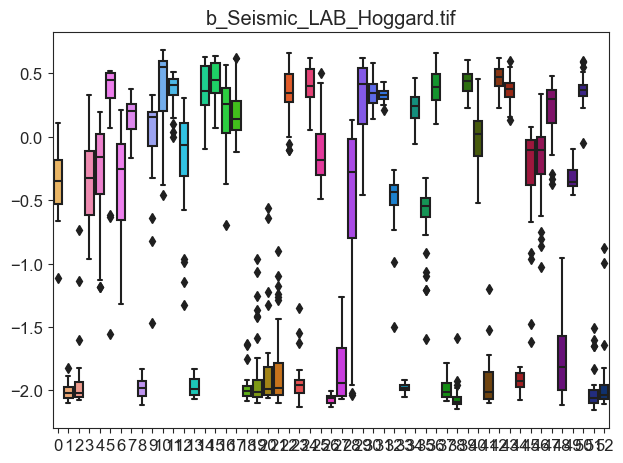

In [ ]:
import beak.methods.som.argsPlot
import beak.methods.som.plot_som_results as plot
import beak.methods.som.move_to_subfolder as mts

argsP = beak.methods.som.argsPlot.Args()

argsP.outsomfile= args.output_file_somspace   # som calculation somspace output text file
argsP.som_x= args.som_x         # som x dimension
argsP.som_y= args.som_y         # som y dimension
argsP.input_file= args.input_file   # Input file(*.lrn)
argsP.dir= args.output_folder            # Input file(*.lrn) or directory where som.dictionary was safet to (/output/som.dictionary)
argsP.grid_type= 'rectangular' # grid type (square or hexa), (rectangular or hexagonal)
argsP.redraw='true'       # whether to draw all plots, or only those required for clustering (true: draw all. false:draw only for clustering).
argsP.outgeofile=args.output_file_geospace     # som geospace results txt file
argsP.dataType='grid'       # Data type (scatter or grid)
argsP.noDataValue='-9999'    # noData value

plot.run_plotting_script(argsP)

subfolder_name = "plots"
images, labels = mts.move_figures(args.output_folder, subfolder_name)

Show all figures that were produced by "plot_som_results.py" and moved into a subfolder.

Boxplot:
> x axis is Cluster ID </br>
> Z axis is original data value </br>
> legend: number of data points in each cluster </br>

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipyplot

# Clear Matplotlib cache
plt.close('all')

# Clear output
clear_output(wait=True)

tabs = [image.split('_')[-2] for image in labels]

print("List of figures:")
print(labels)
#print(tabs)

# Plot the images
#ipyplot.plot_images(images, max_images=50, img_width=250)
ipyplot.plot_class_tabs(images, tabs, max_imgs_per_tab=50, img_width=400)
ipyplot.plot_class_representations(images,  labels, img_width=200, show_url=False)


List of figures:
['geoplot_1.png', 'geoplot_10.png', 'geoplot_11.png', 'geoplot_12.png', 'geoplot_13.png', 'geoplot_14.png', 'geoplot_2.png', 'geoplot_3.png', 'geoplot_4.png', 'geoplot_5.png', 'geoplot_6.png', 'geoplot_7.png', 'geoplot_8.png', 'geoplot_9.png', 'somplot_1.png', 'somplot_10.png', 'somplot_11.png', 'somplot_12.png', 'somplot_13.png', 'somplot_14.png', 'somplot_15.png', 'somplot_2.png', 'somplot_3.png', 'somplot_4.png', 'somplot_5.png', 'somplot_6.png', 'somplot_7.png', 'somplot_8.png', 'somplot_9.png', 'boxplot_1.png', 'boxplot_10.png', 'boxplot_11.png', 'boxplot_12.png', 'boxplot_2.png', 'boxplot_3.png', 'boxplot_4.png', 'boxplot_5.png', 'boxplot_6.png', 'boxplot_7.png', 'boxplot_8.png', 'boxplot_9.png', 'db_score.png', 'cluster_hit_count.png']
